Нам предстоит построить модель, которая предскажет температуру стали на металургическом заводе. Это нужно для оптимизации произвдства.

Целевой признак: последняя измеренная температура.
Метрика: MAE
Данные состоят из  5 файлов, полученных из разных источников.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import tensorflow as tf

pd.set_option('display.max_columns', None)
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

## Предобработка и сборка данных

наша цель - предсказать температуру на финальном замере. Будем собирать все таблички в одну, попути перерабатывая данные

### Таблица temp

In [3]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'])
temp.info()
#нужно убрать наны и еще те значения где всего 1 замер температуры

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [4]:
temp = temp.dropna()
only_one = []
for i in temp.key.unique():
    current_df = temp[temp['key']==i]
    if len(current_df)<2:
        only_one.append(i)
temp = temp.drop(temp[temp['key'].isin(only_one)].index)        
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12265 entries, 0 to 12266
Data columns (total 3 columns):
key             12265 non-null int64
Время замера    12265 non-null datetime64[ns]
Температура     12265 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.3 KB


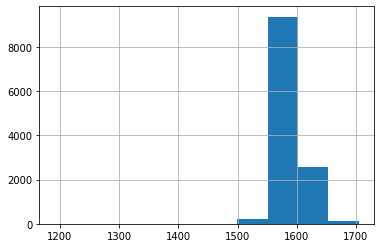

In [5]:
#предобработка
temp['Температура'].hist()
temp[temp['Температура'] < 1450]
temp = temp[temp['Температура'] > 1450] #убрали аутлайнеров снизу

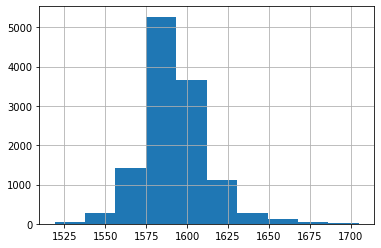

In [6]:
temp['Температура'].hist()

##### Я сперва сделал без предобработки любой, получил на бустинге около 5.8 и решил еще улучшить убрав аутлайнеров.

In [7]:
temp

key        Время замера  Температура
0         1 2019-05-03 11:16:18       1571.0
1         1 2019-05-03 11:25:53       1604.0
2         1 2019-05-03 11:29:11       1618.0
3         1 2019-05-03 11:30:01       1601.0
4         1 2019-05-03 11:30:39       1613.0
...     ...                 ...          ...
12262  2498 2019-08-06 02:19:26       1593.0
12263  2498 2019-08-06 02:25:31       1594.0
12264  2499 2019-08-06 02:40:25       1569.0
12265  2499 2019-08-06 02:54:24       1604.0
12266  2499 2019-08-06 03:00:28       1603.0

[12259 rows x 3 columns]

In [8]:
# начнем конструировать таблицу.
result = []
for i in temp.key.unique():
    current_df = temp[temp['key']==i]
    result.append(current_df[current_df['Время замера'] == current_df['Время замера'].max()]['Температура'].max())

df = pd.DataFrame({'key':temp.key.unique(),'final_temp':result})

In [9]:
#добавим из этой таблицы как фичу начальную температуру
result = []
for i in temp.key.unique():
    current_df = temp[temp['key']==i]
    result.append(current_df[current_df['Время замера'] == current_df['Время замера'].min()]['Температура'].min())  
df['start_temp']=result

In [10]:
#добавим фичу количество замеров
result = []
for i in temp.key.unique():
    current_df = temp[temp['key']==i]
    result.append(len(current_df))  
df['count_temp']=result

In [11]:
#добавим фичу время от первого замера до последнего
result = []
for i in temp.key.unique():
    start_time = temp[temp['key']==i].min()
    end_time = temp[temp['key']==i].max()
    work_time = end_time['Время замера'] - start_time['Время замера']
    result.append(work_time)
    
df['temp_interval'] = result

df['temp_interval'] = df['temp_interval'].astype('timedelta64[s]')

##### Так мы же данные о времени начала и времени конца не берем в фичи, а берем только их разницу. таким образом это уникальная фича отображающая время

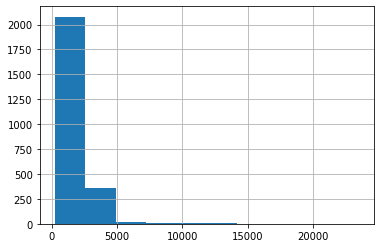

In [12]:
df['temp_interval'].hist()
df = df[df['temp_interval'] < 6000] #отрезали хвост

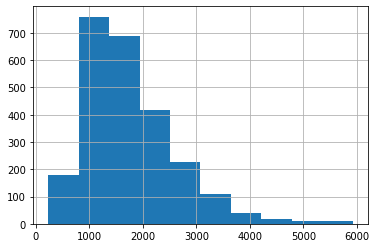

In [13]:
df['temp_interval'].hist()

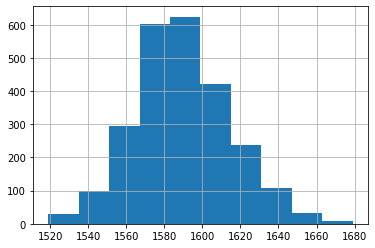

In [14]:
df['start_temp'].hist() #это и так хорошо

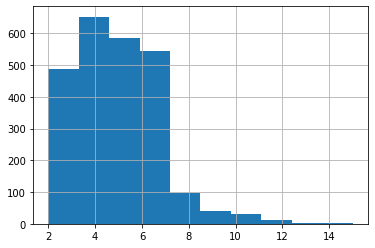

In [15]:
df['count_temp'].hist() #оставим так

### Таблица gas

In [16]:
#только добавим такое
result = []
for i in df.key.unique():
    result.append(gas.loc[gas['key']==i]['Газ 1'].max())
df['gas'] = result

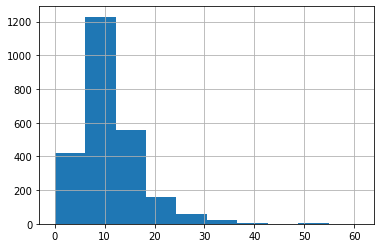

In [17]:
df['gas'].hist()
df = df[df['gas'] < 40]

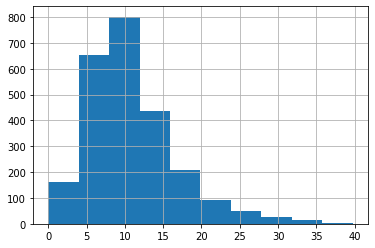

In [18]:
df['gas'].hist()

### Таблица arc

In [19]:
#добавим полное время работы дуги над каждой партией
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])


def givesum(df):
    start = df['Начало нагрева дугой']
    end = df['Конец нагрева дугой']
    return end - start

result = []
for i in df.key.unique():
    current_df = arc[arc['key']==i]
    current_df['sum'] = current_df.apply(givesum,axis=1)
    result.append(current_df['sum'].sum())
    
df['arc_time'] = result
df['arc_time']  = df['arc_time'].astype('timedelta64[s]')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
#покластеризуем
data = arc.copy()
data['time'] = data.apply(givesum,axis=1)
data['time'] = data['time'].astype('timedelta64[s]')
data = data[['Активная мощность', 'Реактивная мощность', 'time']]

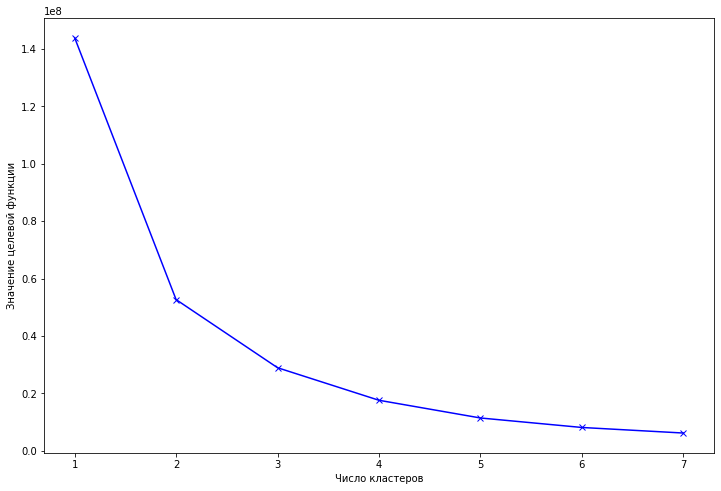

In [21]:
distortion = []

K = range(1, 8)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(data)
    #print('Число кластеров:', k) 
    #print('Значение целевой функции',model.inertia_)
    distortion.append(model.inertia_)
    
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

#5 кластеров будет

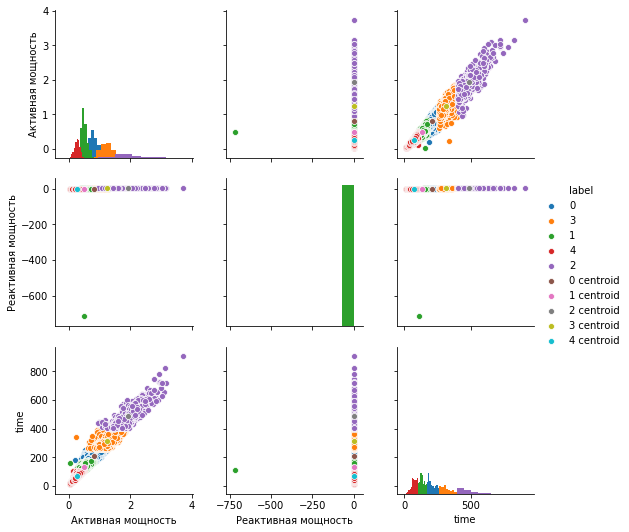

In [22]:
model = KMeans(n_clusters=5, random_state=12345)
model.fit(data)

centroids = pd.DataFrame(model.cluster_centers_, columns=data.columns)
data['label'] =  model.labels_.astype(str)
centroids['label'] = ['0 centroid', '1 centroid', '2 centroid', '3 centroid','4 centroid']
data_all = pd.concat([data, centroids], ignore_index=True)

sns.pairplot(data_all, hue='label', diag_kind='hist')
#по времени и активной мощности что-то похожее на нормальные кластеры

In [23]:
data_all.head(3)

Активная мощность  Реактивная мощность   time label
0           0.976059             0.687084  228.0     0
1           0.805607             0.520285  185.0     0
2           0.744363             0.498805  172.0     0

In [24]:
#попробуем это использывать как фичу
arc['lables'] = model.labels_

result = []
for i in df.key.unique():
    current_df = arc[arc['key']==i]
    result.append(current_df['lables'].mode()[0])
    
df['arc_type'] = result

##### Тут идея была в том, что у нас по 4-8 записей на каждый ключ, а в итоговые фичи мы переносим только по одной на ключ и хотелось бы,что бы была фича отражающая отличия ключей между собой. Поэтому мы разбили записи на кластеры и в итоговые фичи взяли наиболее частый встречающийся кластер этого ключа, что позволило примерно описать происходящее с ключом в пяти строчках одной цифрой.  Это дало прибавку в скоре и поэтому я оставил.

На самом деле конечно это скорее по приколу)

In [25]:
#добавим фичу количество разогревов
result = []
for i in df.key.unique():
    current_df = arc[arc['key']==i]
    result.append(len(current_df))  
df['count_arc']=result

In [26]:
#добавим среднюю активную и реактивуню мощность

result = []
for i in df.key.unique():
    current_df = arc[arc['key']==i]
    result.append(current_df['Активная мощность'].mean())
df['arc_active'] = result
result = []
for i in df.key.unique():
    current_df = arc[arc['key']==i]
    result.append(current_df['Реактивная мощность'].mean())
df['arc_reactive'] = result

In [27]:
#добавим мощность
df['might'] = (df['arc_reactive']**2 + df['arc_active']**2)**0.5

In [28]:
#добавим среднее время нагрева

df['mean_time_arc'] = df['arc_time']/df['count_arc']

In [29]:
#максимально долгое прогретие ***

def givesum(df):
    start = df['Начало нагрева дугой']
    end = df['Конец нагрева дугой']
    return end - start

result = []
for i in df.key.unique():
    current_df = arc[arc['key']==i]
    current_df['sum'] = current_df.apply(givesum,axis=1)
    result.append(current_df['sum'].max())
    
df['arc_time_max'] = result
df['arc_time_max']  = df['arc_time_max'].astype('timedelta64[s]')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


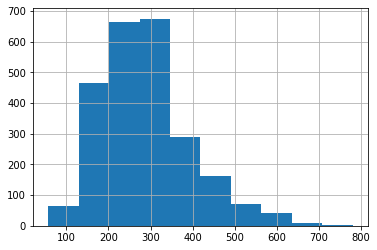

In [30]:
df['arc_time_max'].hist() #норм

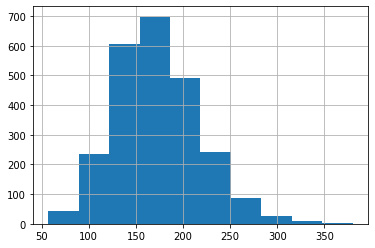

In [31]:
df['mean_time_arc'].hist() #норм

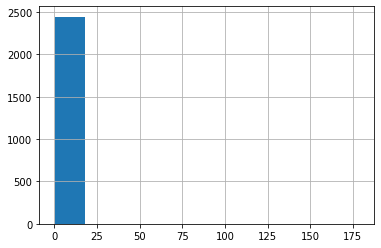

In [32]:
df['might'].hist() #выборос детектед!
df = df[df['might'] <10]

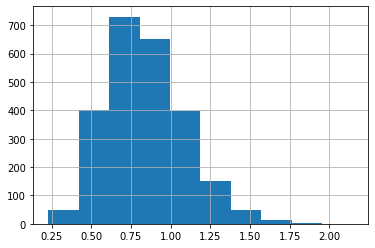

In [33]:
df['might'].hist() #так-то лучше

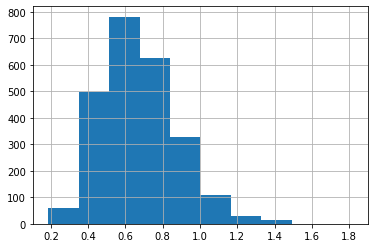

In [34]:
df['arc_active'].hist() # норм

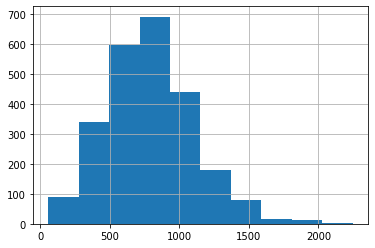

In [35]:
df['arc_time'].hist() #сойдет

### Таблица bulk

In [36]:
#добавляем все булки
df = pd.merge(df,bulk,on=['key'], how='left')

### Таблица wire

In [37]:
#добавляем все виры
df = pd.merge(df,wire,on=['key'], how='left')

### Таблица bulk_time

In [38]:
for i in range(1,16):
    bulk_time['Bulk {}'.format(i)] = pd.to_datetime(bulk_time['Bulk {}'.format(i)] )
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null datetime64[ns]
Bulk 2     22 non-null datetime64[ns]
Bulk 3     1298 non-null datetime64[ns]
Bulk 4     1014 non-null datetime64[ns]
Bulk 5     77 non-null datetime64[ns]
Bulk 6     576 non-null datetime64[ns]
Bulk 7     25 non-null datetime64[ns]
Bulk 8     1 non-null datetime64[ns]
Bulk 9     19 non-null datetime64[ns]
Bulk 10    176 non-null datetime64[ns]
Bulk 11    177 non-null datetime64[ns]
Bulk 12    2450 non-null datetime64[ns]
Bulk 13    18 non-null datetime64[ns]
Bulk 14    2806 non-null datetime64[ns]
Bulk 15    2248 non-null datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [39]:
#время от первого до последнего замера
bulk_time['start'] = bulk_time.drop('key',axis=1).max(axis=1)
bulk_time['end'] = bulk_time.drop('key',axis=1).min(axis=1)
bulk_time['bulk_dif'] = bulk_time['start'] - bulk_time['end']
df = pd.merge(df,bulk_time[['key','bulk_dif']],on=['key'], how='left')
df['bulk_dif']  = df['bulk_dif'].astype('timedelta64[s]')

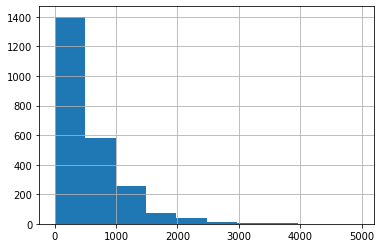

In [40]:
df['bulk_dif'].hist() #подрежем хвост
df = df[df['bulk_dif'] < 3000]

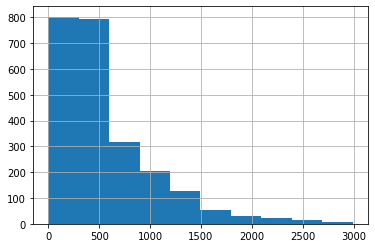

In [41]:
df['bulk_dif'].hist()

### Таблица wire_time

In [42]:
for i in range(1,10):
    wire_time['Wire {}'.format(i)] = pd.to_datetime(wire_time['Wire {}'.format(i)] )
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null datetime64[ns]
Wire 2    1079 non-null datetime64[ns]
Wire 3    63 non-null datetime64[ns]
Wire 4    14 non-null datetime64[ns]
Wire 5    1 non-null datetime64[ns]
Wire 6    73 non-null datetime64[ns]
Wire 7    11 non-null datetime64[ns]
Wire 8    19 non-null datetime64[ns]
Wire 9    29 non-null datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [43]:
#время от первого до последнего замера
wire_time['start'] = wire_time.drop('key',axis=1).max(axis=1)
wire_time['end'] = wire_time.drop('key',axis=1).min(axis=1)
wire_time['wire_dif'] = wire_time['start'] - wire_time['end']
df = pd.merge(df,wire_time[['key','wire_dif']],on=['key'], how='left')
df['wire_dif']  = df['wire_dif'].astype('timedelta64[s]')

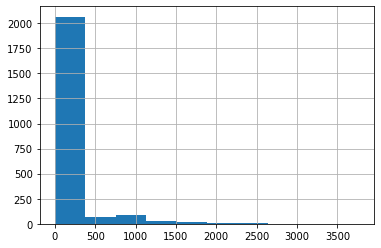

In [44]:
df['wire_dif'].hist()
df = df[df['wire_dif'] < 2500]

## Разбиение на выборки и подбор моделей

In [45]:
df =df.reset_index()
df = df.drop('index',axis=1)

In [46]:
df.columns

Index(['key', 'final_temp', 'start_temp', 'count_temp', 'temp_interval', 'gas',
       'arc_time', 'arc_type', 'count_arc', 'arc_active', 'arc_reactive',
       'might', 'mean_time_arc', 'arc_time_max', 'Bulk 1', 'Bulk 2', 'Bulk 3',
       'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10',
       'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1',
       'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8',
       'Wire 9', 'bulk_dif', 'wire_dif'],
      dtype='object')

In [47]:
#разбиваем на тест трейн и валид
values = df.drop(['final_temp','key','arc_type'],axis=1)
target = df['final_temp']

#нормализуем
x = values.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
values = min_max_scaler.fit_transform(x)
values = pd.DataFrame(values)

values = pd.merge(values,df['arc_type'], right_index = True, left_index=True, how='left')#категориальная фича

values_train, values_test_and_valid, target_train, target_test_and_valid = train_test_split(values, target, test_size=0.4, random_state=111)
values_valid, values_test, target_valid, target_test = train_test_split(values_test_and_valid, target_test_and_valid, test_size=0.5, random_state=111)

print("Трейн 60%: ",values_train.shape,target_train.shape)
print("Валидация 20%: ",values_valid.shape,target_valid.shape)
print("Тест 20%: ",values_test.shape,target_test.shape)

Трейн 60%:  (1371, 38) (1371,)
Валидация 20%:  (457, 38) (457,)
Тест 20%:  (457, 38) (457,)


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


### Котбуст

In [48]:
cat_features =['arc_type']

cat_model = CatBoostRegressor(iterations=30000, 
                          learning_rate=0.01,
                          loss_function='MAE',
                          early_stopping_rounds=2000
                         )
cat_model.fit(values_train, target_train, verbose=True,plot = False,cat_features=cat_features,eval_set=(values_valid, target_valid))

#bestTest = 5.483201378
#bestIteration = 11750

0:	learn: 7.9048422	test: 7.9789706	best: 7.9789706 (0)	total: 51.4ms	remaining: 25m 41s
1:	learn: 7.8827875	test: 7.9605174	best: 7.9605174 (1)	total: 55ms	remaining: 13m 44s
2:	learn: 7.8643434	test: 7.9508484	best: 7.9508484 (2)	total: 58.3ms	remaining: 9m 43s
3:	learn: 7.8446410	test: 7.9360559	best: 7.9360559 (3)	total: 62.5ms	remaining: 7m 48s
4:	learn: 7.8253179	test: 7.9213484	best: 7.9213484 (4)	total: 71.4ms	remaining: 7m 8s
5:	learn: 7.8065156	test: 7.9090182	best: 7.9090182 (5)	total: 157ms	remaining: 13m 6s
6:	learn: 7.7857499	test: 7.8908306	best: 7.8908306 (6)	total: 161ms	remaining: 11m 30s
7:	learn: 7.7693679	test: 7.8761432	best: 7.8761432 (7)	total: 164ms	remaining: 10m 16s
8:	learn: 7.7523032	test: 7.8671695	best: 7.8671695 (8)	total: 255ms	remaining: 14m 9s
9:	learn: 7.7319802	test: 7.8526192	best: 7.8526192 (9)	total: 259ms	remaining: 12m 56s
10:	learn: 7.7091681	test: 7.8361629	best: 7.8361629 (10)	total: 268ms	remaining: 12m 11s
11:	learn: 7.6934667	test: 7.8272

In [49]:
"""
# подбираем гиперпараметры
grid = {'learning_rate': [0.03, 0.01],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

model = CatBoostRegressor(iterations=20000, 
                          loss_function='MAE',
                          early_stopping_rounds=2000
                         )
randomized_search_result = model.grid_search(grid, values_train, target_train, verbose=True,plot = False)
model.get_params()

#best:
#{ 'depth': 4,
# 'l2_leaf_reg': 5,
# 'learning_rate': 0.01}

"""

"\n# подбираем гиперпараметры\ngrid = {'learning_rate': [0.03, 0.01],\n        'depth': [4, 6, 10],\n        'l2_leaf_reg': [1, 3, 5, 7, 9]}\n\nmodel = CatBoostRegressor(iterations=20000, \n                          loss_function='MAE',\n                          early_stopping_rounds=2000\n                         )\nrandomized_search_result = model.grid_search(grid, values_train, target_train, verbose=True,plot = False)\nmodel.get_params()\n\n#best:\n#{ 'depth': 4,\n# 'l2_leaf_reg': 5,\n# 'learning_rate': 0.01}\n\n"

In [50]:
cat_model = CatBoostRegressor(iterations=50000, #повысим, надо что бы она сама останавливалась от перекормки.
                          learning_rate=0.01,
                          loss_function='MAE',
                          early_stopping_rounds=2000,
                          depth= 4,
                          l2_leaf_reg = 5,
                         )
cat_model.fit(values_train, target_train, verbose=True, plot=False, eval_set=(values_valid, target_valid)) 

#bestTest = 5.353589951
#bestIteration = 32931

0:	learn: 7.9117860	test: 7.9851631	best: 7.9851631 (0)	total: 1.72ms	remaining: 1m 26s
1:	learn: 7.8927779	test: 7.9712318	best: 7.9712318 (1)	total: 3.11ms	remaining: 1m 17s
2:	learn: 7.8740904	test: 7.9519045	best: 7.9519045 (2)	total: 4.53ms	remaining: 1m 15s
3:	learn: 7.8586942	test: 7.9421646	best: 7.9421646 (3)	total: 5.92ms	remaining: 1m 13s
4:	learn: 7.8404283	test: 7.9233045	best: 7.9233045 (4)	total: 7.34ms	remaining: 1m 13s
5:	learn: 7.8201599	test: 7.9074379	best: 7.9074379 (5)	total: 10.3ms	remaining: 1m 25s
6:	learn: 7.8069270	test: 7.8988714	best: 7.8988714 (6)	total: 17.2ms	remaining: 2m 2s
7:	learn: 7.7899470	test: 7.8863455	best: 7.8863455 (7)	total: 95.2ms	remaining: 9m 54s
8:	learn: 7.7750718	test: 7.8754536	best: 7.8754536 (8)	total: 97.2ms	remaining: 8m 59s
9:	learn: 7.7601443	test: 7.8642485	best: 7.8642485 (9)	total: 99.4ms	remaining: 8m 16s
10:	learn: 7.7466069	test: 7.8573680	best: 7.8573680 (10)	total: 102ms	remaining: 7m 41s
11:	learn: 7.7312743	test: 7.846

### Keras

In [51]:
#точно такое же разбитие, только заполним наны нулями, иначе их не принимает керас

values = df.drop(['final_temp','key','arc_type'],axis=1)
target = df['final_temp']

#нормализуем
x = values.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
values = min_max_scaler.fit_transform(x)
values = pd.DataFrame(values)

values = pd.merge(values,df['arc_type'], right_index = True, left_index=True, how='left')#категориальная фича
values = values.fillna(0)
values_train, values_test_and_valid, target_train, target_test_and_valid = train_test_split(values, target, test_size=0.4, random_state=111)
values_valid, values_test_zero, target_valid, target_test = train_test_split(values_test_and_valid, target_test_and_valid, test_size=0.5, random_state=111)
#values_test_zero отметим их что у них занулены наны


print("Трейн 60%: ",values_train.shape,target_train.shape)
print("Валидация 20%: ",values_valid.shape,target_valid.shape)
print("Тест 20%: ",values_test.shape,target_test.shape)

Трейн 60%:  (1371, 38) (1371,)
Валидация 20%:  (457, 38) (457,)
Тест 20%:  (457, 38) (457,)


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [52]:
seed = 111
np.random.seed(seed)
import torch
torch.manual_seed(seed)

def baseline_model():

    model = Sequential()
    model.add(Dense(38, input_dim=38, kernel_initializer='normal', activation='relu'))
    model.add(Dense(200, kernel_initializer='normal', activation='relu'))
    model.add(Dense(200, kernel_initializer='normal', activation='relu'))#100
    model.add(Dense(24, kernel_initializer='normal', activation='relu'))

    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss="mean_absolute_error",optimizer='adam')
    

    return model

In [53]:
model = baseline_model()
my_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=50)] #ранняя остановка

model.fit(
    x=values_train.values, y=target_train.values, batch_size=None, epochs=500, verbose=1, callbacks=my_callbacks,
    validation_data=(values_valid, target_valid),steps_per_epoch = len(values_train),validation_steps = len(values_valid))


Train on 1371 samples, validate on 457 samples
Epoch 1/500
1371/1371 [==============================] - 7s 5ms/sample - loss: 253.8430 - val_loss: 84.4006
Epoch 2/500
1371/1371 [==============================] - 6s 4ms/sample - loss: 73.0028 - val_loss: 54.5163
Epoch 3/500
1371/1371 [==============================] - 6s 4ms/sample - loss: 45.9081 - val_loss: 30.6915
Epoch 4/500
1371/1371 [==============================] - 6s 4ms/sample - loss: 32.1430 - val_loss: 19.1007
Epoch 5/500
1371/1371 [==============================] - 6s 4ms/sample - loss: 25.1874 - val_loss: 17.9583
Epoch 6/500
1371/1371 [==============================] - 6s 4ms/sample - loss: 21.5953 - val_loss: 20.2414
Epoch 7/500
1371/1371 [==============================] - 6s 4ms/sample - loss: 21.9058 - val_loss: 13.5134
Epoch 8/500
1371/1371 [==============================] - 6s 4ms/sample - loss: 19.5752 - val_loss: 12.3680
Epoch 9/500
1371/1371 [==============================] - 7s 5ms/sample - loss: 20.9635 - val_los

## Тестируем модель

### Catboost

In [54]:
cat_prediction = cat_model.predict(values_test)

print("Итоговая ошибка на тесте: ", mean_absolute_error(cat_prediction, target_test))


#Итоговая ошибка на тесте:  5.322409575578872

Итоговая ошибка на тесте:  5.322409575578872


### Keras

In [55]:
prediction = model.predict(values_test_zero) #тут зануленные наны

print("Итоговая ошибка на тесте: ", mean_absolute_error(prediction, target_test))

#Итоговая ошибка на тесте:  5.6583879666985775  #потерял лаки сид на котором было 5.3)

Итоговая ошибка на тесте:  5.68810581065372


### Скрещиваем кота и бобра

In [56]:
preds = pd.DataFrame(prediction,cat_prediction)
preds = preds.reset_index()
preds['mean'] = preds.mean(axis=1)

In [57]:
print("Итоговая ошибка скрещенных моделей: ", mean_absolute_error(preds['mean'], target_test))

Итоговая ошибка скрещенных моделей:  5.306024442408241


#### Вывод: Скрестив две модели мы добились итоговой ошибки в 5.3 МАЕ при определении последней температуры на нашем заводе.

было 5.1 на удачном сиде(

### Анализ модели

In [58]:
names = df.drop(['final_temp','key','arc_type'],axis=1).columns
importance = cat_model.get_feature_importance(prettified=True).sort_values('Feature Id')
importance =importance.reset_index()
names = pd.Series(names, name='names')
names=names.reset_index()
names['index']=names['index'].astype(str)
names = names.sort_values('index')
final_importance = pd.merge(importance,names, right_on = "index", left_on='Feature Id', how='left')
final_importance = final_importance[['names','Feature Id','Importances']]
final_importance.sort_values('Importances',ascending=False)

names Feature Id  Importances
0      start_temp          0    22.128837
31       arc_time          4    15.481965
19         Wire 1         26     6.009599
8          Bulk 6         16     5.415002
33     arc_active          6     5.094124
12  temp_interval          2     5.082468
17        Bulk 14         24     3.433592
20         Wire 2         27     3.299370
2    arc_time_max         10     3.108573
32      count_arc          5     3.071758
36  mean_time_arc          9     3.038619
15        Bulk 12         22     2.916234
23            gas          3     2.870067
35          might          8     2.596175
18        Bulk 15         25     2.575716
29       bulk_dif         35     2.357123
34   arc_reactive          7     2.231345
5          Bulk 3         13     2.064054
30       wire_dif         36     1.666663
1      count_temp          1     1.309749
3          Bulk 1         11     1.116449
6          Bulk 4         14     1.079353
37            NaN   arc_type     0.590484
14        Bulk 11         21     0.407278
13        Bulk 10         20     0.397393
25         Wire 6         31     0.266635
7          Bulk 5         15     0.200607
16        Bulk 13         23     0.107363
27         Wire 8         33     0.040835
21         Wire 3         28     0.028138
28         Wire 9         34     0.009827
11         Bulk 9         19     0.004180
4          Bulk 2         12     0.000422
22         Wire 4         29     0.000000
26         Wire 7         32     0.000000
10         Bulk 8         18     0.000000
9          Bulk 7         17     0.000000
24         Wire 5         30     0.000000

# Отчет по решению

Следуя плану мы изучили данные, составили единую таблицу, провели чистку и обучили модель. В процессе пробывали добавлять разные фичи (в том числе одну при помощи кластерного анализа) и оставляли качественные.<br/>
При построении моедли использовали catboost и ради интереса нейросеть с регрессией, итоговый результат получили путем их сложения.<br/>
Самое трудное в задании было разобраться со всеми данными в разных таблицах, впрочем ничего сложного в том что бы компилировать поочередно данные не было.<br/>
Согласно проекту основными шагами были: Переработка и сборка данных по каждой таблице, Подбор моделей и гиперпараметров, Тестирование и анализ моделей.<br/>
Итоговое качество было 5.1, но в процессе дискуссии с ревьюером поменял архитектуру нейросети на более предсказуемую и скор опустился до 5.3